Extracting ./mnist\train-images-idx3-ubyte.gz
Extracting ./mnist\train-labels-idx1-ubyte.gz
Extracting ./mnist\t10k-images-idx3-ubyte.gz
Extracting ./mnist\t10k-labels-idx1-ubyte.gz
(55000, 784)
(55000, 10)


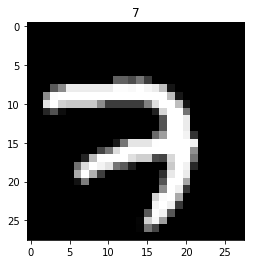

ValueError: Variable rnn/basic_lstm_cell/kernel already exists, disallowed. Did you mean to set reuse=True or reuse=tf.AUTO_REUSE in VarScope? Originally defined at:

  File "C:\Users\Owner\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 1718, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access
  File "C:\Users\Owner\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 3392, in create_op
    op_def=op_def)
  File "C:\Users\Owner\Anaconda3\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)


In [2]:
#Leaving comments to explain what is occuring
#imports of Libraries: tensorflow, numpy: python math functions
#matplot, os
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import matplotlib.pyplot as plt
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"]="3"


tf.set_random_seed(1)
np.random.seed(1)

# Hyper Parameters
BATCH_SIZE = 64
TIME_STEP = 28          # rnn time step / image height
INPUT_SIZE = 28         # rnn input size / image width
LR = 0.01               # learning rate

# data
mnist = input_data.read_data_sets('./mnist', one_hot=True)              # they has been normalized to range (0,1)
test_x = mnist.test.images[:2000]
test_y = mnist.test.labels[:2000]

# plot one example
print(mnist.train.images.shape)     # (55000, 28 * 28)
print(mnist.train.labels.shape)   # (55000, 10)
plt.imshow(mnist.train.images[0].reshape((28, 28)), cmap='gray')
plt.title('%i' % np.argmax(mnist.train.labels[0]))
plt.show()

# tensorflow placeholders
tf_x = tf.placeholder(tf.float32, [None, TIME_STEP * INPUT_SIZE])       # shape(batch, 784)
image = tf.reshape(tf_x, [-1, TIME_STEP, INPUT_SIZE])                   # (batch, height, width, channel)
tf_y = tf.placeholder(tf.int32, [None, 10])                             # input y

# RNN
rnn_cell = tf.contrib.rnn.BasicLSTMCell(num_units=64)
outputs, (h_c, h_n) = tf.nn.dynamic_rnn(
    rnn_cell,                   # cell you have chosen
    image,                      # input
    initial_state=None,         # the initial hidden state
    dtype=tf.float32,           # must given if set initial_state = None
    time_major=False,           # False: (batch, time step, input); True: (time step, batch, input)
)
output = tf.layers.dense(outputs[:, -1, :], 10)              # output based on the last output step

loss = tf.losses.softmax_cross_entropy(onehot_labels=tf_y, logits=output)           # compute cost
train_op = tf.train.AdamOptimizer(LR).minimize(loss)

accuracy = tf.metrics.accuracy(          # return (acc, update_op), and create 2 local variables
    labels=tf.argmax(tf_y, axis=1), predictions=tf.argmax(output, axis=1),)[1]

sess = tf.Session()
init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer()) # the local var is for accuracy_op
sess.run(init_op)     # initialize var in graph

for step in range(1200):    # training
    b_x, b_y = mnist.train.next_batch(BATCH_SIZE)
    _, loss_ = sess.run([train_op, loss], {tf_x: b_x, tf_y: b_y})
    if step % 50 == 0:      # testing
        accuracy_ = sess.run(accuracy, {tf_x: test_x, tf_y: test_y})
        print('train loss: %.4f' % loss_, '| test accuracy: %.2f' % accuracy_)

# print 10 predictions from test data
test_output = sess.run(output, {tf_x: test_x[:10]})
pred_y = np.argmax(test_output, 1)
print(pred_y, 'prediction number')
print(np.argmax(test_y[:10], 1), 'real number')